# Homework 2

In [6]:
%pip install -U sklearn pandas imblearn matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 181.2 kB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.8/960.8 kB 123.9 kB/s eta 0:00:00a 0:00:01
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.1/241.1 kB 332.9 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 199.6 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 164.2 kB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.


# Preprocessing

There are three binary features: `ever_married = Yes/No`, `Residence_type = Urban/Rural`, `gender = Male/Female`, therefore all of them are replaced with a boolean value.

`work_type` and `smoking_status` have more possible values, so they are one-hot encoding is used for them.

In [7]:
import pandas as pd
import functools

data = pd.read_csv("brain_stroke.csv")

data["ever_married"] = data["ever_married"] == "Yes"
data["urban"] = data["Residence_type"] == "Urban"
data = data.drop("Residence_type", axis=1)
data["male"] = data["gender"] == "Male"
data = data.drop("gender", axis=1)

def one_hot(data, column):
  return data.drop(column, axis=1).join(pd.get_dummies(data[column], prefix=column))

data = functools.reduce(one_hot, ["work_type", "smoking_status"], data)
data = data.rename(lambda x: x.lower(), axis=1)

data.head()

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,urban,male,work_type_govt_job,work_type_private,work_type_self-employed,work_type_children,smoking_status_unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,True,228.69,36.6,1,True,True,0,1,0,0,0,1,0,0
1,80.0,0,1,True,105.92,32.5,1,False,True,0,1,0,0,0,0,1,0
2,49.0,0,0,True,171.23,34.4,1,True,False,0,1,0,0,0,0,0,1
3,79.0,1,0,True,174.12,24.0,1,False,False,0,0,1,0,0,0,1,0
4,81.0,0,0,True,186.21,29.0,1,True,True,0,1,0,0,0,1,0,0


# Train/test split

In [8]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.1)
train_X, train_y = train.drop("stroke", axis=1), train["stroke"]
test_X, test_y = test.drop("stroke", axis=1), test["stroke"]

# normalization
mean, std = train_X.mean(), train_X.std()
train_X = (train_X - mean) / std
test_X = (test_X - mean) / std

# Metrics

We'll be measuring accuracy, precision, recall and f1 score.

In [9]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_curve, RocCurveDisplay

def metrics(name, pred, gt):
  print(f"Results for {name}")
  print(" - accuracy: ", accuracy_score(gt, pred))
  print(" - precision: ", precision_score(gt, pred))
  print(" - recall: ", recall_score(gt, pred))
  print(" - f1 score: ", f1_score(gt, pred))

def draw_roc(name, scores, gt):
  print(f"ROC curve for {name}")
  fpr, tpr, _ = roc_curve(gt, scores)
  RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

# Logistic regression

Applied balanced class weight due to class imbalance.

Results for Logistic Regression
 - accuracy:  0.751503006012024
 - precision:  0.11764705882352941
 - recall:  0.8
 - f1 score:  0.20512820512820512
ROC curve for Logistic Regression


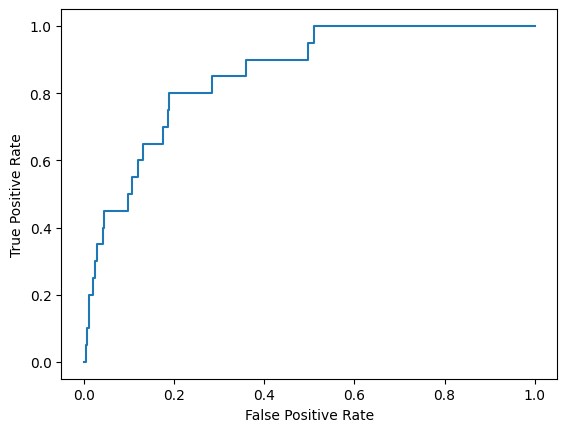

In [22]:
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report

model = LogisticRegression(max_iter=1000, class_weight="balanced").fit(train_X, train_y)

pred = model.predict(test_X)
scores = model.decision_function(test_X)

metrics("Logistic Regression", pred, test_y)
draw_roc("Logistic Regression", scores, test_y)

# Random forest

Similarly to previous, applied balanced class weight. Reduced max depth in order to prevent overfitting.

Results for Random Forest
 - accuracy:  0.8076152304609219
 - precision:  0.1346153846153846
 - recall:  0.7
 - f1 score:  0.22580645161290322
ROC curve for Random Forest


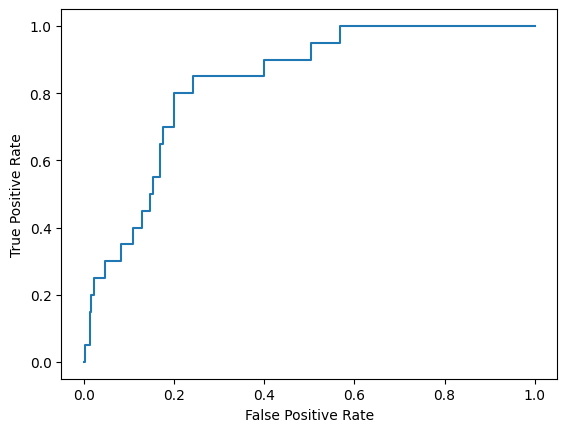

In [27]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(class_weight="balanced", max_depth=6).fit(train_X, train_y)

pred = model.predict(test_X)
scores = model.predict_proba(test_X)[:,1]

metrics("Random Forest", pred, test_y)
draw_roc("Random Forest", scores, test_y)

# Neural network

This time in order to account for class imbalance applied oversampling. Also reduced hidden layer sizes to reduce overfitting.

Results for Random Forest
 - accuracy:  0.7775551102204409
 - precision:  0.09734513274336283
 - recall:  0.55
 - f1 score:  0.16541353383458646
ROC curve for Random Forest


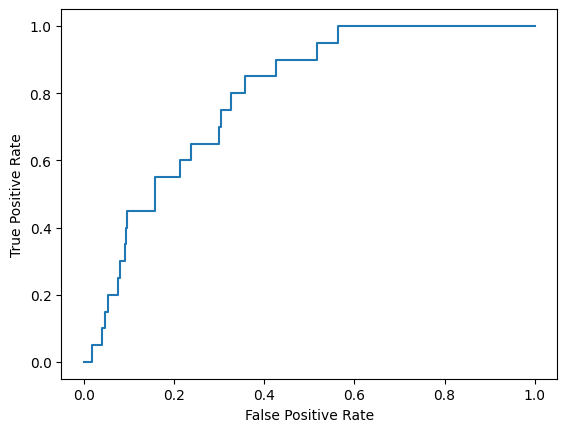

In [30]:
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE

oversample = SMOTE()

X, y = oversample.fit_resample(train_X, train_y)

model = MLPClassifier(max_iter=10_000, hidden_layer_sizes=(7,)).fit(X, y)

pred = model.predict(test_X)
scores = model.predict_proba(test_X)[:,1]

metrics("Random Forest", pred, test_y)
draw_roc("Random Forest", scores, test_y)

# Summary

Both logistic regression and random forest classifiers provide decent, consistent metrics. MLP takes much longer to train and provides slightly worse and less reliable results (high susceptibility to seed selection).